# # Analyse Exploratoire - Données Starbucks
# 
# Exploration des données financières SEC 2010-2024

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

In [3]:
# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
# %%
# Chargement des données
df = pd.read_csv('../data/raw/financial/starbucks_financial_metrics.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Shape: {df.shape}")
print(f"Période: {df['date'].min()} - {df['date'].max()}")
print(f"Métriques: {df['metric'].unique()}")

Shape: (983, 6)
Période: 2006-10-01 00:00:00 - 2025-03-30 00:00:00
Métriques: ['Revenues' 'NetIncomeLoss' 'Assets' 'StockholdersEquity'
 'OperatingIncomeLoss']


In [6]:
# %%
# Vue d'ensemble
df.head(10)

,metric,value,date,period,form,year
0,Revenues,9774600000,2009-09-27,FY,10-K,2009
1,Revenues,5257400000,2010-03-28,Q2,10-Q,2010
2,Revenues,2534700000,2010-03-28,Q2,10-Q,2010
3,Revenues,7869400000,2010-06-27,Q3,10-Q,2010
4,Revenues,2612000000,2010-06-27,Q3,10-Q,2010
5,Revenues,10707400000,2010-10-03,FY,10-K,2010
6,Revenues,10707400000,2010-10-03,FY,10-K,2010
7,Revenues,2950800000,2011-01-02,Q1,10-Q,2011
8,Revenues,5736500000,2011-04-03,Q2,10-Q,2011
9,Revenues,5736500000,2011-04-03,Q2,10-Q,2011


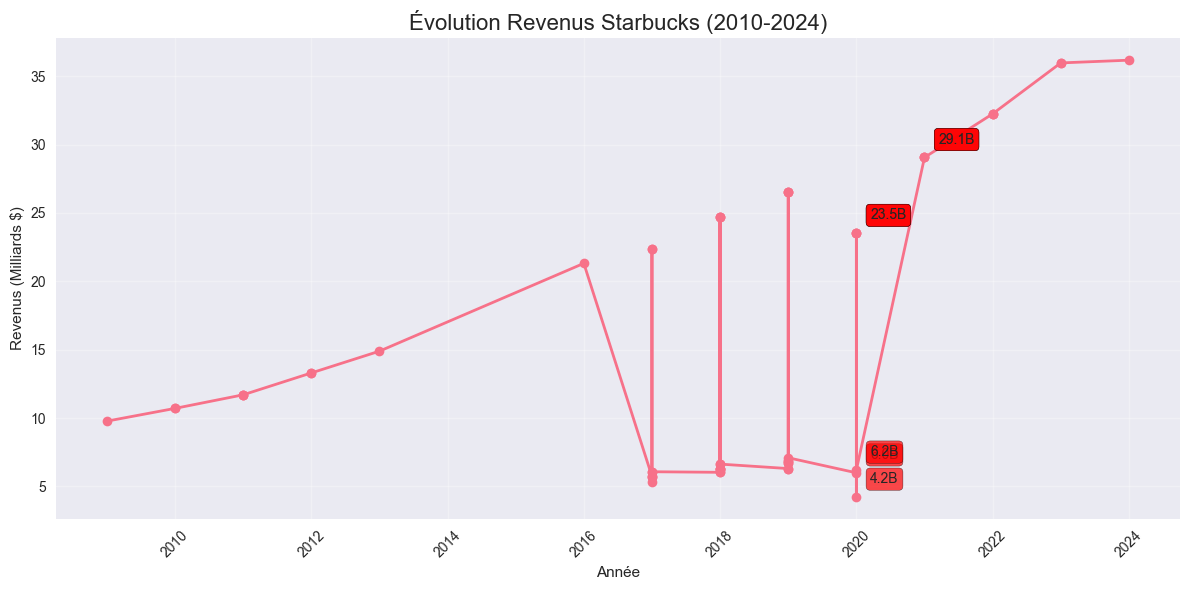

In [7]:
# %%
# Revenus annuels (10-K uniquement)
revenues_annual = df[
    (df['metric'] == 'Revenues') & 
    (df['form'] == '10-K')
].sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(revenues_annual['year'], revenues_annual['value'] / 1e9, marker='o', linewidth=2)
plt.title('Évolution Revenus Starbucks (2010-2024)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Revenus (Milliards $)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Annotations des points clés
for i, row in revenues_annual.iterrows():
    if row['year'] in [2020, 2021]:  # COVID impact
        plt.annotate(f"{row['value']/1e9:.1f}B", 
                    xy=(row['year'], row['value']/1e9),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

plt.tight_layout()
plt.show()

In [8]:
# %%
# Calcul croissance YoY
revenues_annual['revenue_growth'] = revenues_annual['value'].pct_change() * 100

print("Croissance annuelle des revenus:")
for _, row in revenues_annual.iterrows():
    if not pd.isna(row['revenue_growth']):
        print(f"{row['year']}: {row['revenue_growth']:.1f}%")


Croissance annuelle des revenus:
2010: 9.5%
2010: 0.0%
2011: 9.3%
2011: 0.0%
2011: 0.0%
2012: 13.7%
2012: 0.0%
2013: 12.0%
2016: 43.1%
2017: -73.1%
2017: -7.7%
2017: 6.9%
2017: 295.4%
2017: 0.0%
2017: -74.5%
2017: 6.6%
2017: 0.0%
2018: -0.7%
2018: 0.0%
2018: 4.6%
2018: 0.0%
2018: -0.1%
2018: 292.1%
2018: -74.5%
2018: 292.1%
2018: 0.0%
2018: -73.2%
2018: 0.0%
2019: -4.9%
2019: 0.0%
2019: 8.2%
2019: 0.0%
2019: 288.5%
2019: 0.0%
2019: 0.0%
2019: -74.5%
2019: 0.0%
2019: 5.2%
2020: -15.5%
2020: -29.6%
2020: 457.0%
2020: 0.0%
2020: 0.0%
2020: -73.6%
2021: 368.5%
2021: 0.0%
2021: 0.0%
2022: 11.0%
2022: 0.0%
2022: 0.0%
2023: 11.6%
2023: 0.0%
2024: 0.6%


In [9]:
# %%
# Analyse saisonnalité (données trimestrielles)
revenues_quarterly = df[
    (df['metric'] == 'Revenues') & 
    (df['form'] == '10-Q')
].copy()

revenues_quarterly['quarter'] = revenues_quarterly['period']
revenues_quarterly = revenues_quarterly.sort_values('date')

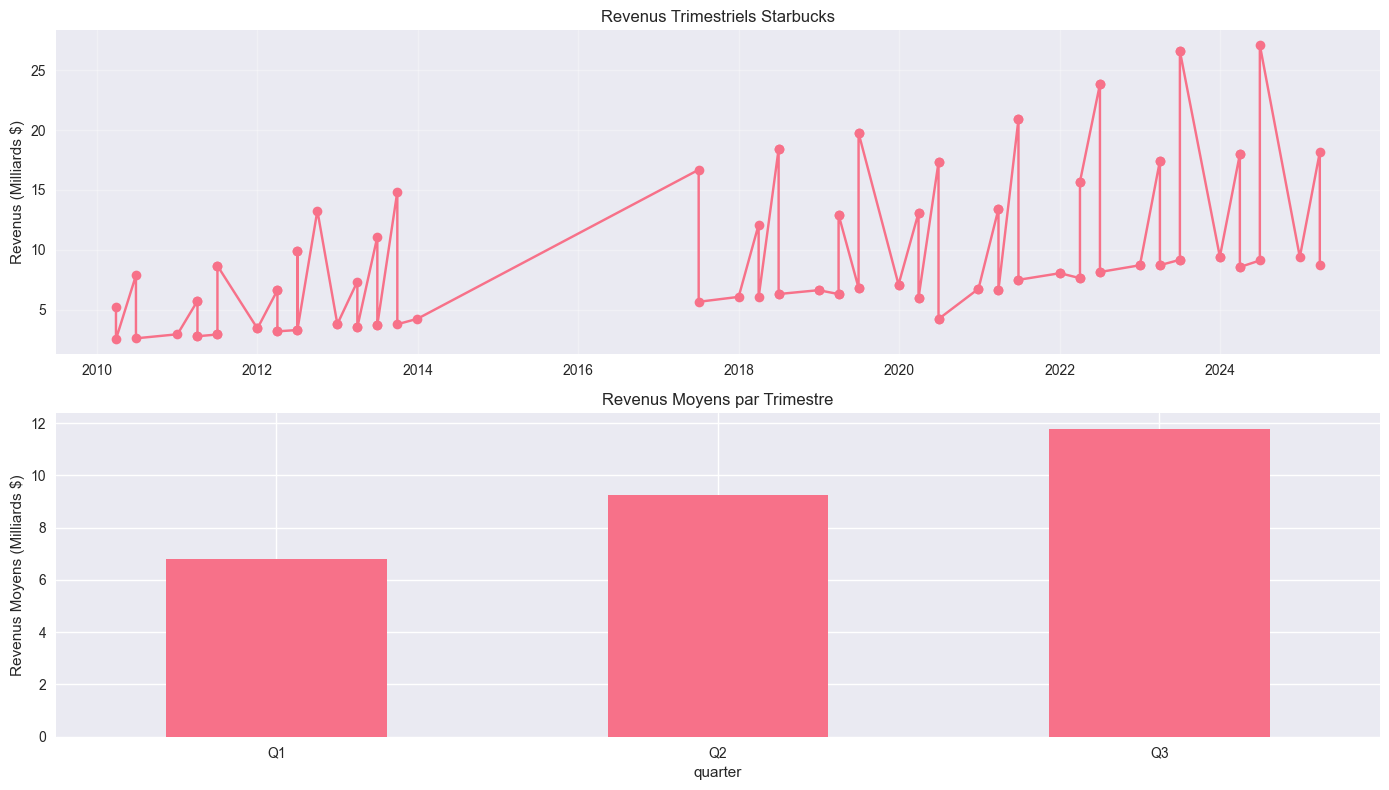

In [10]:
# Graphique saisonnalité
plt.figure(figsize=(14, 8))

# Subplot 1: Évolution trimestrielle
plt.subplot(2, 1, 1)
plt.plot(revenues_quarterly['date'], revenues_quarterly['value'] / 1e9, marker='o')
plt.title('Revenus Trimestriels Starbucks')
plt.ylabel('Revenus (Milliards $)')
plt.grid(True, alpha=0.3)

# Subplot 2: Patterns saisonniers
plt.subplot(2, 1, 2)
quarterly_avg = revenues_quarterly.groupby('quarter')['value'].mean() / 1e9
quarterly_avg.plot(kind='bar')
plt.title('Revenus Moyens par Trimestre')
plt.ylabel('Revenus Moyens (Milliards $)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [11]:
# %%
# Comparaison toutes métriques
metrics_annual = df[df['form'] == '10-K'].pivot_table(
    index='year', 
    columns='metric', 
    values='value', 
    aggfunc='sum'
)


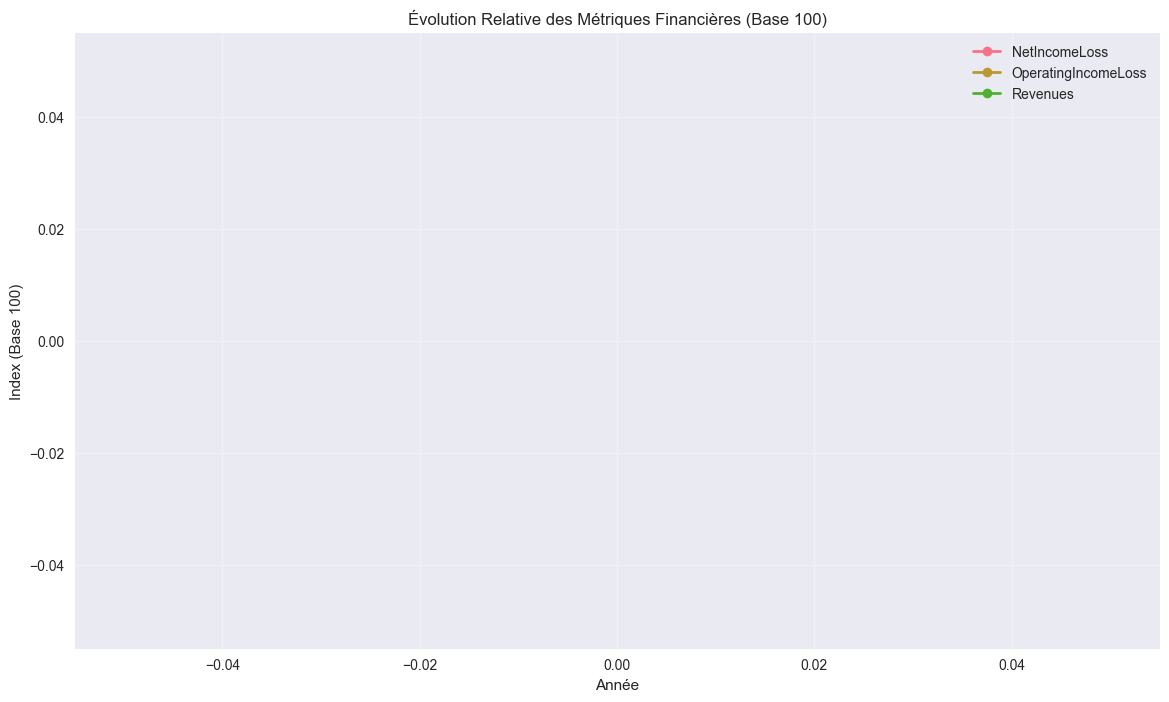

In [12]:
# Normalisation pour comparaison
metrics_normalized = metrics_annual.div(metrics_annual.iloc[0]) * 100

plt.figure(figsize=(14, 8))
for col in metrics_normalized.columns:
    if col in ['Revenues', 'NetIncomeLoss', 'OperatingIncomeLoss']:
        plt.plot(metrics_normalized.index, metrics_normalized[col], 
                marker='o', label=col, linewidth=2)

plt.title('Évolution Relative des Métriques Financières (Base 100)')
plt.xlabel('Année')
plt.ylabel('Index (Base 100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# %%
# Marges et ratios
latest_data = metrics_annual.iloc[-1]
print("Données les plus récentes:")
print(f"Revenus: ${latest_data['Revenues']/1e9:.1f}B")
if 'NetIncomeLoss' in latest_data:
    net_margin = (latest_data['NetIncomeLoss'] / latest_data['Revenues']) * 100
    print(f"Marge nette: {net_margin:.1f}%")
if 'OperatingIncomeLoss' in latest_data:
    op_margin = (latest_data['OperatingIncomeLoss'] / latest_data['Revenues']) * 100
    print(f"Marge opérationnelle: {op_margin:.1f}%")

Données les plus récentes:
Revenus: $36.2B
Marge nette: 10.4%
Marge opérationnelle: 15.0%


In [14]:
# %%
# Impact COVID visible ?
covid_period = revenues_annual[
    (revenues_annual['year'] >= 2019) & 
    (revenues_annual['year'] <= 2022)
]

print("\nImpact COVID-19:")
for _, row in covid_period.iterrows():
    print(f"{row['year']}: ${row['value']/1e9:.1f}B ({row['revenue_growth']:.1f}%)")


Impact COVID-19:
2019: $6.3B (-4.9%)
2019: $6.3B (0.0%)
2019: $6.8B (8.2%)
2019: $6.8B (0.0%)
2019: $26.5B (288.5%)
2019: $26.5B (0.0%)
2019: $26.5B (0.0%)
2019: $6.7B (-74.5%)
2019: $6.7B (0.0%)
2019: $7.1B (5.2%)
2020: $6.0B (-15.5%)
2020: $4.2B (-29.6%)
2020: $23.5B (457.0%)
2020: $23.5B (0.0%)
2020: $23.5B (0.0%)
2020: $6.2B (-73.6%)
2021: $29.1B (368.5%)
2021: $29.1B (0.0%)
2021: $29.1B (0.0%)
2022: $32.3B (11.0%)
2022: $32.3B (0.0%)
2022: $32.3B (0.0%)


In [15]:
# %%
# Export données nettoyées pour modélisation
clean_annual = revenues_annual[['year', 'date', 'value']].copy()
clean_annual.columns = ['year', 'date', 'revenue']
clean_annual.to_csv('../../data/processed/starbucks_annual_revenue.csv', index=False)

print("Données nettoyées exportées vers data/processed/")
print(f"Période d'analyse: {clean_annual['year'].min()}-{clean_annual['year'].max()}")
print(f"Points de données: {len(clean_annual)}")

OSError: Cannot save file into a non-existent directory: '..\..\data\processed'